In [1]:
import numpy as np
import chess
import chess.pgn
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from joblib import dump, load

In [14]:
model_reg = load("./reg-log")
model_ml = keras.models.load_model("./model_ml.h5")

In [21]:
pgn = open("../../data/lichess_elite_2021-06.pgn")
parties = 4500

In [16]:
def count_value_(board, color):
    val = 0
    val += len(board.pieces(color=color, piece_type=chess.PAWN))
    val += len(board.pieces(color=color, piece_type=chess.KNIGHT))*3
    val += len(board.pieces(color=color, piece_type=chess.BISHOP))*3
    val += len(board.pieces(color=color, piece_type=chess.ROOK))*5
    val += len(board.pieces(color=color, piece_type=chess.QUEEN))*9

    return val

In [17]:
def get_base_vect(size):
    arr = [0 for i in range(size)]
    return np.array(arr)

def get_vect(board):
    pieces = [chess.PAWN, chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN, chess.KING]
    colors = [chess.WHITE, chess.BLACK]
    vect = get_base_vect(len(pieces)*2*64)
    for i in range(len(colors)):
        for e in range(len(pieces)):
            lst = board.pieces(color=colors[i], piece_type=pieces[e])
            for position in lst:
                vect[position*len(pieces)*2 + i*len(pieces) + e] = 1
    return vect

In [22]:
good_pv = np.zeros((20))
total = np.zeros((20))

pv_acc = 0
lr_acc = 0
dl_acc = 0

total_lr = np.zeros((20))
good_lr = np.zeros((20))

total_dl = np.zeros((20))
good_dl = np.zeros((20))

for index in range(parties):

    game = chess.pgn.read_game(pgn)
    if game.headers["Result"] == "1/2-1/2":
        continue

    winner = 1 if game.headers["Result"] == "1-0" else 2
    
    board = game.board()
    counter = 0
    tt = len(list(game.mainline_moves()))

    x = []
    y = []

    for move in game.mainline_moves():
        board.push(move)
        counter+=1

# valeurs des pièces
        white_value = count_value_(board, chess.WHITE)
        black_value = count_value_(board, chess.BLACK)
        diff = white_value - black_value
        pourcent = int(counter / tt * 20) -1
        pred = 1
        if diff != 0:
            pred = 2 if diff < 0 else 1
        if winner == pred:
            good_pv[pourcent] += 1
            pv_acc += 1

        total[pourcent] += 1

    # logistique reg
        y.append(get_vect(board))
        x.append(pourcent)

    try:
        preds = model_reg.predict(np.array(y))
        for i in range(len(preds)):
            pred = 2-preds[i]
            if pred == winner:
                good_lr[x[i]] += 1
                lr_acc += 1
            total_lr[x[i]] += 1
    except:
        pass

    try:
        preds = model_ml.predict(np.array(y))
        for i in range(len(preds)):
            pred = 1 if preds[i][0]>0.5 else 2
            if pred == winner:
                good_dl[x[i]] += 1
                dl_acc += 1
            total_dl[x[i]] += 1
    except:
        pass
    
    if index % 100 == 0:
        print(index) 

print("valeur des pièces:", pv_acc / np.sum(total)) 
print("regression log", lr_acc / np.sum(total_lr))
print("nn", dl_acc / np.sum(total_dl))

0
100
200
300
500
600
700
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3600
3700
3900
4000
4100
4200
valeur des pièces: 0.591553286216881
regression log 0.5934431333478626
nn 0.5973411376443849


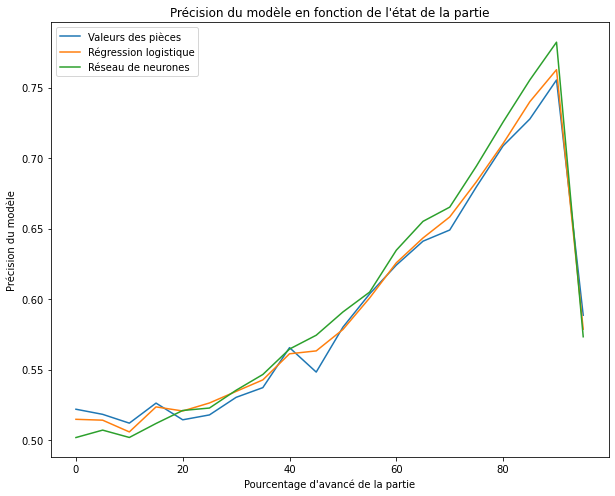

In [24]:
plt.figure(figsize=(10,8))
plt.title("Précision du modèle en fonction de l'état de la partie")
plt.plot(list(range(0, 100, 5)), good_pv/total, label="Valeurs des pièces")
plt.plot(list(range(0, 100, 5)), good_lr/total_lr, label="Régression logistique")
plt.plot(list(range(0, 100, 5)), good_dl/total_dl, label="Réseau de neurones")
plt.xlabel("Pourcentage d'avancé de la partie")
plt.ylabel("Précision du modèle")
plt.legend()

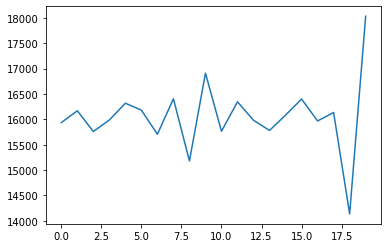

In [25]:
plt.plot(total)